In [5]:


import kagglehub
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

## Download latest version
path = kagglehub.dataset_download("sameepvani/nasa-nearest-earth-objects")



In [6]:

df = pd.read_csv(f"{path}/neo.csv")
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [7]:
features = ['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance','absolute_magnitude']
target = 'hazardous'

In [8]:
df.iloc[[10,11]]

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
10,54049873,(2020 OT6),0.252671,0.564989,58430.697200,3.833750e+07,Earth,False,20.11,True
11,54099949,(2020 XW4),0.152952,0.342011,64393.928316,7.198311e+07,Earth,False,21.20,False


In [9]:
mask = df[target] == True

In [ ]:
N = 500
np.random.seed(123)

df_true = df[df[target] == True]
df_false = df[df[target] == False]

df_subset_true = df_true.iloc[np.random.choice(N, size=N, replace=False)]
df_subset_false = df_false.iloc[np.random.choice(N, size=N, replace=False)]

df_subset = pd.concat([df_subset_true, df_subset_false])



In [11]:

from sklearn.model_selection import train_test_split

# Split the dataframe into 80% train and 20% test
train_df, test_df = train_test_split(
    df_subset,
    test_size=0.2,
    random_state=1,
    stratify=df_subset['hazardous']
)

# Optionally display the shapes of the train and test sets
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")



Train shape: (3200, 10)
Test shape: (800, 10)


In [12]:
from sklearn.model_selection import train_test_split

# Split train_df further into 80% train and 20% validation, stratified on 'hazardous'
train_split_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=1,
    stratify=train_df['hazardous']
)

# Optionally, print the shapes
print(f"Train split shape: {train_split_df.shape}")
print(f"Validation shape: {val_df.shape}")


Train split shape: (2560, 10)
Validation shape: (640, 10)


In [13]:
train_split_df[features].head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
626,0.004837,0.010815,26616.227297,3.541983e+07,28.70
1032,0.008027,0.017949,17307.465656,4.267134e+07,27.60
1792,0.016771,0.037501,53020.567025,2.695878e+07,26.00
1183,0.006991,0.015633,51780.919691,3.132443e+07,27.90
1573,0.006061,0.013553,55475.405871,6.610768e+07,28.21


In [14]:

X_train, Y_train = train_split_df[features].to_numpy(), train_split_df[target].apply(lambda x: int(x)).to_numpy()
X_val, Y_val = val_df[features].to_numpy(), val_df[target].apply(lambda x: int(x)).to_numpy()
X_test, Y_test = test_df[features].to_numpy(), test_df[target].apply(lambda x: int(x)).to_numpy()


In [15]:
y = np.where(Y_train==1, +1, -1)

# Make mean 0 and standard diviation 1
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_test)
# ---YOUR CODE ENDS HERE---

print("Shapes:", X_tr.shape, X_te.shape, " (+1 count):", (Y_train==+1).sum(), " (-1 count):", (Y_train==-1).sum())

Shapes: (2560, 5) (800, 5)  (+1 count): 1280  (-1 count): 0


In [16]:
n_qubits = 5
SEED = 123

dev = qml.device("default.qubit", wires=n_qubits, shots=None, seed=SEED)

# @qml.qnode(dev)
def feature_map_angle(x, wires=None, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    qml.AngleEmbedding(x*scale, wires=wires, rotation="Y")
    if entangle:
        for i in range(len(wires)-1):
            qml.CZ(wires[i:i+1+1])
        qml.CZ([wires[-1], wires[0]])
    # ---YOUR CODE ENDS HERE---
    return None
    
@qml.qnode(dev)
def all_bitstring_probabilities(x, z, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    feature_map_angle(x, wires=list(range(len(x))), scale = scale, entangle=entangle)
    qml.adjoint(feature_map_angle)(z, wires=list(range(len(z))), scale=scale, entangle=entangle)
    probs = qml.probs()
    # ---YOUR CODE ENDS HERE---
    return probs

def overlap_probability(x, z, scale=1.0, entangle=True):
    return all_bitstring_probabilities(x, z, scale=scale, entangle=entangle)[0]

# Quick sanity check for x_5

def quantum_kernel(A, B, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    tqdmA = tqdm(A)
    K = np.array([[overlap_probability(a,b, scale=scale) for b in B] for a in tqdmA])
    
    # ---YOUR CODE ENDS HERE---
    return K

In [ ]:
K_tr_old = quantum_kernel(X_tr, X_tr)

  1%|          | 13/2560 [00:40<2:17:46,  3.25s/it]

In [ ]:
@qml.qnode(dev)
def feature_map_angle(x, wires=None, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    qml.AngleEmbedding(x*scale, wires=wires, rotation="Y")
    if entangle:
        for i in range(len(wires)-1):
            qml.CZ(wires[i:i+1+1])
        qml.CZ([wires[-1], wires[0]])
    # ---YOUR CODE ENDS HERE---
    return qml.state()









    

In [ ]:
X_pre = np.stack([feature_map_angle(x, wires=list(range(len(x)))) for x in tqdm(X_tr)])

100%|██████████| 2560/2560 [00:01<00:00, 1553.87it/s]


In [ ]:
# Compute the kernel matrix in a memory-efficient way (row by row)
k = np.empty((X_pre.shape[0], X_pre.shape[0]), dtype=np.float32)
a = tqdm(X_pre)
for i, psi_i in enumerate(a):
    dot_products = np.abs(np.dot(X_pre, psi_i.conj()))**2
    k[i, :] = dot_products


100%|██████████| 2560/2560 [00:00<00:00, 19755.22it/s]


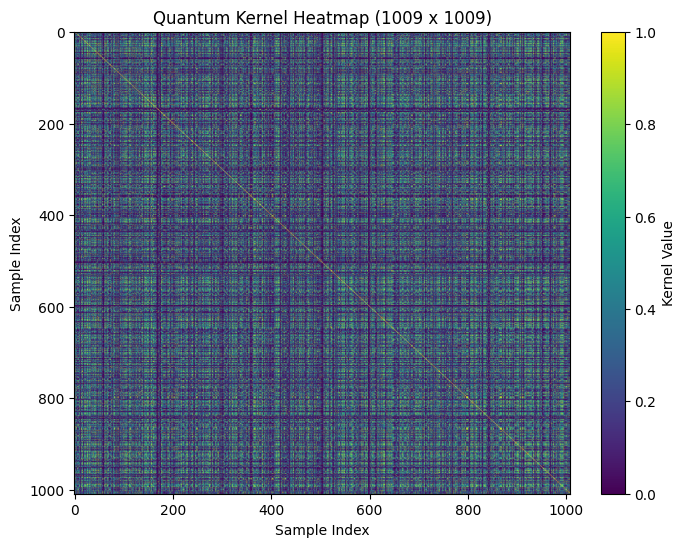

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize a central submatrix (e.g., 200x200) of the kernel with a heatmap
N = 1009
if k.shape[0] > N:
    start = k.shape[0] // 2 - N // 2
    end = start + N
    k_vis = k[start:end, start:end]
else:
    k_vis = k

plt.figure(figsize=(8, 6))
plt.imshow(k_vis, cmap='viridis', aspect='auto')
plt.colorbar(label='Kernel Value')
plt.title(f'Quantum Kernel Heatmap ({k_vis.shape[0]} x {k_vis.shape[1]})')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()


In [ ]:
X_pre_val = np.stack([feature_map_angle(x, wires=list(range(len(x)))) for x in tqdm(X_val)])

100%|██████████| 640/640 [00:00<00:00, 1527.09it/s]


In [ ]:
# Compute the kernel matrix in a memory-efficient way (row by row)
k_tr_val = np.empty((X_pre_val.shape[0], X_pre.shape[0]), dtype=np.float32)
a = tqdm(X_pre_val)
for i, psi_i in enumerate(a):
    dot_products = np.abs(np.dot(X_pre, psi_i.conj()))**2
    k_tr_val[i, :] = dot_products

100%|██████████| 640/640 [00:00<00:00, 19276.54it/s]


In [ ]:
import pickle

# Save X_train, X_val, X_test, Y_train, Y_val, Y_test
with open("features_labels.pkl", "wb") as f:
    pickle.dump({
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "Y_train": Y_train,
        "Y_val": Y_val,
        "Y_test": Y_test
    }, f)

# Save k and k_tr_val
with open("kernels.pkl", "wb") as f:
    pickle.dump({
        "k": k,
        "k_tr_val": k_tr_val
    }, f)


In [ ]:
import pickle

# Load all previously saved data (features_labels.pkl and kernels.pkl)
with open("features_labels.pkl", "rb") as f:
    features_labels = pickle.load(f)
    X_train = features_labels["X_train"]
    X_val = features_labels["X_val"]
    X_test = features_labels["X_test"]
    Y_train = features_labels["Y_train"]
    Y_val = features_labels["Y_val"]
    Y_test = features_labels["Y_test"]

with open("kernels.pkl", "rb") as f:
    kernels = pickle.load(f)
    k = kernels["k"]
    k_tr_val = kernels["k_tr_val"]


              precision    recall  f1-score   support

           0       0.97      0.61      0.75       320
           1       0.71      0.98      0.83       320

    accuracy                           0.80       640
   macro avg       0.84      0.80      0.79       640
weighted avg       0.84      0.80      0.79       640

Confusion Matrix:
[[194 126]
 [  5 315]]


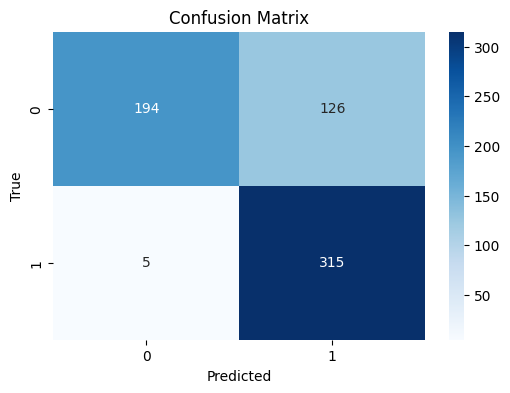

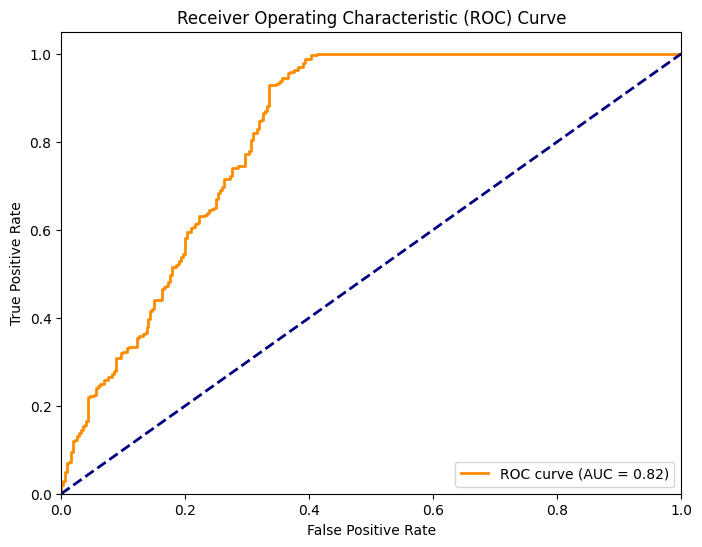

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Train SVM on the precomputed kernel (k)
svm = SVC(kernel='precomputed')
svm.fit(k, Y_train)

# Predict on validation set using k_tr_val
y_pred = svm.predict(k_tr_val)

# Print classification report
print(classification_report(Y_val, y_pred))


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(Y_val, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix for better visualization
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for the positive class (assuming binary classification)
# SVC does not have predict_proba by default with precomputed kernels but has decision_function
y_scores = svm.decision_function(k_tr_val)

fpr, tpr, thresholds = roc_curve(Y_val, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

